# Think Bayes: Chapter 3

This notebook presents example code and exercise solutions for Think Bayes.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [53]:
from __future__ import print_function, division

%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import display
from scipy.stats import hypergeom
from sympy import symbols
import matplotlib.pyplot as plt
import mythinkbayes as mtb
import numpy as np
import pandas as pd

'Done'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'Done'

## The Dice problem

Suppose I have a box of dice that contains a 4-sided die, a 6-sided
die, an 8-sided die, a 12-sided die, and a 20-sided die.

Suppose I select a die from the box at random, roll it, and get a 6.
What is the probability that I rolled each die?

In [2]:
class DiceExample(mtb.PMF):
    
    def likelihood(self, data, hypo):
        """Return P(data | hypo) to be used when updating the prior."""
        if hypo < data:
            return 0
        return 1 / hypo

ex = DiceExample([4, 6, 8, 12, 20])

for roll in [6, 6, 8, 7, 7, 5, 4]:
    display('Rolled %d' % roll, ex.update(roll))

'Rolled 6'

4     0.000000
6     0.392157
8     0.294118
12    0.196078
20    0.117647
dtype: float64

'Rolled 6'

4     0.000000
6     0.525624
8     0.295664
12    0.131406
20    0.047306
dtype: float64

'Rolled 8'

4     0.000000
6     0.000000
8     0.735134
12    0.217817
20    0.047049
dtype: float64

'Rolled 7'

4     0.000000
6     0.000000
8     0.817574
12    0.161496
20    0.020930
dtype: float64

'Rolled 7'

4     0.000000
6     0.000000
8     0.875713
12    0.115320
20    0.008967
dtype: float64

'Rolled 5'

4     0.000000
6     0.000000
8     0.915845
12    0.080403
20    0.003751
dtype: float64

'Rolled 4'

4     0.000000
6     0.000000
8     0.943248
12    0.055206
20    0.001545
dtype: float64

## The train problem

The Train problem has the same likelihood as the Dice problem.

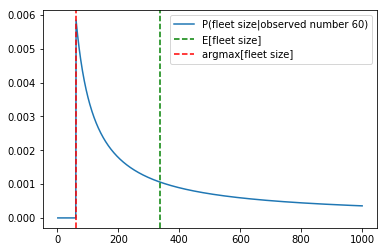

Expectation = 335.04414
Argmax = 61.00000


In [20]:
class TrainExample(mtb.PMF):
    
    def likelihood(self, data, hypo):
        return 1. / hypo * (data < hypo)

ex = TrainExample(np.arange(1, 1001))
ex.update(60)

plt.plot(ex.index, ex.values, label='P(fleet size|observed number 60)')
plt.axvline(ex.expectation(), label='E[fleet size]', color='green', linestyle='--')
plt.axvline(ex.idxmax(), label='argmax[fleet size]', color='red', linestyle='--')
plt.legend()
plt.show()

print('Expectation = %.5lf' % ex.expectation())
print('Argmax = %.5lf' % ex.idxmax())

## Sensitivity to the prior

Here's a function that solves the train problem for different priors and data

In [4]:
highs = [500, 1000, 2000] # Number of trains in a fleet.
data = [30, 60, 90]       # Train number observed.

for high in highs:
    ex = TrainExample(np.arange(1, high + 1))
    for d in data:
        ex.update(d)
    print('%d, %.4lf' % (high, ex.expectation()))

500, 151.8496
1000, 164.3056
2000, 171.3382


## Power law prior

Now let's try it with a power law prior.

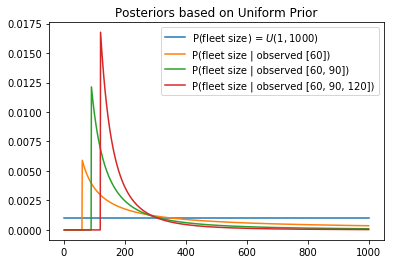

In [5]:
hypos = np.arange(1, 1001)
observations = [60, 90, 120]

ex = TrainExample(hypos, np.ones(len(hypos)))
plt.plot(ex.index, ex.values, label='P(fleet size) = $U(1, %d)$' % hypos.max())
for i, obs in enumerate(observations):
    ex.update(obs)
    plt.plot(ex.index, ex.values, label='P(fleet size | observed %s)' % str(observations[:i+1]))
plt.legend()
plt.title('Posteriors based on Uniform Prior')
plt.show()
    

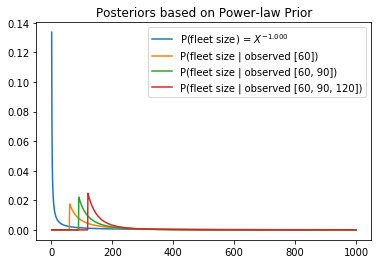

In [6]:
alpha = 1.0
prior = (1./hypos) ** alpha
ex = TrainExample(hypos, prior)
plt.plot(ex.index, ex.values, label='P(fleet size) = $X^{-%.3lf}$' % alpha)
for i, obs in enumerate(observations):
    ex.update(obs)
    plt.plot(ex.index, ex.values, label='P(fleet size | observed %s)' % str(observations[:i+1]))
plt.legend()
plt.title('Posteriors based on Power-law Prior')
plt.show()

Now let's see what the posteriors look like after observing one train.

Observe that the expectation for the uniform prior has greater changes in the expectations as you increase the high value.

In [7]:
alpha = 1.0
highs = [500, 1000, 2000]
observations = [60]

print('High, Observation, Uniform Posterior Expectation, Power Law Posterior Expectation')

for high in highs:
    exu = TrainExample(np.arange(1, high+1))
    exp = TrainExample(np.arange(1, high+1), np.arange(1, high + 1) ** -alpha)
    for obs in observations:
        exu.update(obs)
        exp.update(obs)
        print('%d, %d, %.4lf, %.4lf' % (high, obs, exu.expectation(), exp.expectation()))

High, Observation, Uniform Posterior Expectation, Power Law Posterior Expectation
500, 60, 207.0792, 143.8123
1000, 60, 333.4199, 178.5474
2000, 60, 552.1790, 215.5689


## Credible intervals

To compute credible intervals, we can use the `Percentile` method on the posterior.

In [21]:
# Testing a simple CDF class.
ex_pmf = TrainExample(range(1, 1001))
ex_pmf.update(60)
ex_cdf = mtb.CDF.from_pmf(ex_pmf)
ex_cdf.percentile(5), ex_cdf.percentile(95)

(69, 869)

Also, a CDF can be a better way to visualize distributions.

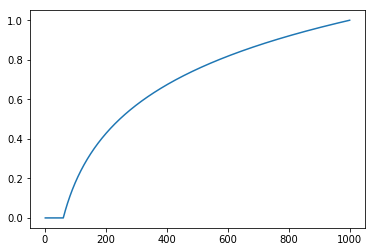

In [22]:
plt.plot(ex_cdf.index, ex_cdf.values)
plt.show()

## Exercises

**Exercise:** To write a likelihood function for the locomotive problem, we had
to answer this question:  "If the railroad has `N` locomotives, what
is the probability that we see number 60?"

The answer depends on what sampling process we use when we observe the
locomotive.  In this chapter, I resolved the ambiguity by specifying
that there is only one train-operating company (or only one that we
care about).

But suppose instead that there are many companies with different
numbers of trains.  And suppose that you are equally likely to see any
train operated by any company.
In that case, the likelihood function is different because you
are more likely to see a train operated by a large company.

As an exercise, implement the likelihood function for this variation
of the locomotive problem, and compare the results.

**Ambiguous Question**

This question had me going in circles for some time before I finally capitulated and looked at the solution. Downey's solution (below) is based on the assumptions that we know how many trains A has ($N$) and how many trains the remaining companies have ($M$). If you already know how many trains there are ($N$ and $M$), then I cannot understand the point of computing the posterior over various values of $N$, which is what the original train exercise was doing.

**Solution from Downey**

Suppose Company A has N trains and all other companies have M.
The chance that we would observe one of Company A's trains is $N/(N+M)$.
Given that we observe one of Company A's trains, the chance that we
observe number 60 is $1/N$ for $N \ge 60$.

The product of these probabilities is $1/(N+M)$, which is just the
probability of observing any given train.

If N<<M, this converges to a constant, which means that all value of $N$
have the same likelihood, so we learn nothing about how many trains
Company A has.

If N>>M, this converges to $1/N$, which is what we saw in the previous
solution.

More generally, if M is unknown, we would need a prior distribution for
M, then we can do a two-dimensional update, and then extract the posterior
distribution for N.

We'll see how to do that soon.

**Exercise:** Suppose I capture and tag 10 rock hyraxes.  Some time later, I capture another 10 hyraxes and find that two of them are already tagged.  How many hyraxes are there in this environment?

As always with problems like this, we have to make some modeling assumptions. 

1) For simplicity, you can assume that the environment is reasonably isolated, so the number of hyraxes does not change between observations.

2) And you can assume that each hyrax is equally likely to be captured during each phase of the experiment, regardless of whether it has been tagged.  In reality, it is possible that tagged animals would avoid traps in the future, or possible that the same behavior that got them caught the first time makes them more likely to be caught again.  But let's start simple.

I suggest the following notation:

*  `N`: total population of hyraxes 
*  `K`: number of hyraxes tagged in the first round 
*  `n`: number of hyraxes caught in the second round
*  `k`: number of hyraxes in the second round that had been tagged

So `N` is the hypothesis and `(K, n, k)` make up the data.  The probability of the data, given the hypothesis, is the probability of finding `k` tagged hyraxes out of `n` if (in the population) `K` out of `N` are tagged. 

If you are familiar with the hypergeometric distribution, you can use the hypergeometric PMF to compute the likelihood function.  Otherwise, you can figure it out using combinatorics.

The distribution in question can be specified:

$P(N | (K, n, k)) = \frac{P(N) \times P((K, n, k) | N)}{P((k, n, k))}$

For $P(N)$, we can assume a uniform prior with an arbitrary upper bound and lower bound at $K + (n - k)$, since you catch $K$ hyraxes in the first round and at least $n-k$ new hyraxes in the second round.

For $P((K, n, k) | N)$ we use the hypergeometric distribution. Without knowing the hypergeometric distribution, this would be more difficult.

We don't have to worry about $P((K, n, k))$, as it gets computed when we normalize.

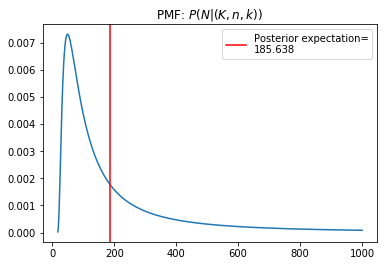

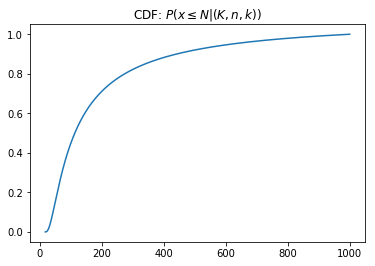

In [63]:
K = 10    # Number caught and tagged in first round.
n = 10    # Number caught and tagged in second round.
k = 2     # Number of already-tagged hyraxes caught in second round.

m = K + (n - k)  # Minimum possible number of hyraxes.
M = 1000         # Max possible number of hyraxes.

# PMF with uniform prior.
ex = mtb.PMF(range(m, M + 1))

# Update prior over N, given (K, n, k) fixed values defined above.
# Use the hypergeometric pmf to model the likelihood of (K, n, k) given K.
# There is a fantastic example on the scipy.stats documentation:
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.hypergeom.html
for N in ex.hypos:
    ex[N] *= hypergeom(N, K, n).pmf(k)

ex.normalize()

plt.plot(ex.index, ex.values)
plt.axvline(ex.expectation(), label='Posterior expectation=\n%.3lf' % ex.expectation(), color='red')
plt.title('PMF: $P(N | (K, n, k))$')
plt.legend()
plt.show()

ex_cdf = mtb.CDF.from_pmf(ex)
plt.plot(ex_cdf.index, ex_cdf.values)
plt.title('CDF: $P(x \leq N | (K, n, k))$')
plt.show()